<h2>  Infection segmentation using Unet </h2>
<p> In this notebook we train an construct and construct an Unet Model which can efficiently construct an infection mask no matter what dataset or what type of image file(.nii,.jpg or .png) the ct scans are</p>

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib #for loading nii files
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf #for deep learning
from keras.optimizers import Adam

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import IPython
from IPython.display import display
from PIL import Image
import matplotlib.image as mi
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras_unet.models import custom_unet
#from keras_unet.models import vanilla_unet
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import backend as K
import keras
from IPython.display import FileLink

In [25]:
def get_images(filename,model):
    img = cv2.imread(filename)
    i2 = cv2.imread(filename)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(128,128))
    img = img.reshape(128,128,1)
    min_val = img.min()
    max_val = img.max()
    img = (img - min_val) / (max_val - min_val)*255
    img2 = img[np.newaxis, :, :, :]
    print(img.shape)
    pmask = model.predict(img2)
    pmask = np.squeeze(pmask)
    return i2,img,pmask


<h2>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Training </h2>
<p><b> Steps:- </b></p>
<ol>
    <li> Define extra metrics like dice_coeff,iou_coef etc.</li>
    <li> read nii files </li>
    <li> Convert the nii files to image arrays</li>
    <li> Normalize the image arrays (pixel range 0-255)</li>
    <li> Perform Train Test Split (70%-30%)</li>
    <li> Construct the unet model</li>
    <li> Fit the data to the model </li>
    <li> Save the model(best wights) </li>
</ol>

<h4>Define extra metrics like dice_coeff,iou_coef etc.</h4>

In [5]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    score = (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3])+K.sum(y_pred, [1, 2, 3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def recall(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.round(y_true_f)
    y_pred_f = tf.round(y_pred_f)
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    re = intersection/(tf.reduce_sum(y_true_f)+1)
    return re

def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.round(y_true_f)
    y_pred_f = tf.round(y_pred_f)
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    pr = intersection/(tf.reduce_sum(y_pred_f)+1)
    return pr

<h4> read nii files </h4>

In [8]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [9]:
data = pd.read_csv(r"Dataset2\metadata.csv")
data.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


<h4>Convert the nii files to image arrays</h4>

In [10]:
CT = []
Infection_Mask = []
img_size = 128

for case in range(len(data)): #Concat all cases to list
    ct = read_nii(data['ct_scan'][case])
    mask = read_nii(data['infection_mask'][case])
    
    for imgsize in range(ct.shape[2]): #Convert pixals to 1-d array
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        Infection_Mask.append(mask_img[..., np.newaxis])

In [11]:
CT = np.array(CT)
Infection_Mask = np.array(Infection_Mask)

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)


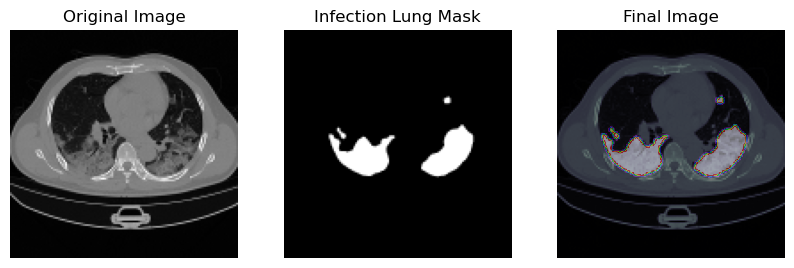

In [24]:
ans = []
ans.append(CT[612])
ans.append(Infection_Mask[612])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
titles = ['Original Image', 'Infection Lung Mask','Final Image']
for i in range(2):
    ax[i].imshow(ans[i],cmap='gray')
    print(ans[i].shape)
    ax[i].set_title(titles[i], fontsize=12)
    ax[i].axis('off')
    
ax[2].imshow(ans[0],cmap='bone')
ax[2].imshow(ans[1],alpha = 0.5, cmap = "nipy_spectral")
print(ans[i].shape)
ax[2].set_title(titles[2], fontsize=12)
ax[2].axis('off')

# Show the plot
plt.show()

<h4> Normalize the image arrays (pixel range 0-255) </h4>

In [14]:
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)*255

<h4> Perform Train Test Split (70%-30%) </h4>

In [15]:
from sklearn.model_selection import train_test_split
CT_train, CT_test, Mask_train, Mask_test = train_test_split(norm_data,Infection_Mask, test_size = 0.3)
print(CT_train.shape,Mask_train.shape)
print(CT_test.shape,Mask_test.shape)

(2464, 128, 128, 1) (2464, 128, 128, 1)
(1056, 128, 128, 1) (1056, 128, 128, 1)


<h4> Construct the unet model </h4>

In [27]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate,MaxPool2D,Concatenate
from keras.models import Model

def encoder(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c1 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c2 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c1)
    p1 = MaxPool2D((2, 2), (2, 2))(c2)
    return c2, p1

def decoder(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    up = UpSampling2D((2, 2))(x)
    concat = Concatenate()([up, skip])
    c1 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c2 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c1)
    return c2

def middlepoint(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c1 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c2 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c1)
    return c2

In [28]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((128, 128, 1))
    
    #encoder
    
    p0 = inputs
    c1, p1 = encoder(p0, 16)
    c2, p2 = encoder(p1, 32)
    c3, p3 = encoder(p2, 64)
    c4, p4 = encoder(p3, 128)
    
    #middle part
    
    bn = middlepoint(p4, 256)
    
    #decoder
    
    u1 = decoder(bn, c4, 128) 
    u2 = decoder(u1, c3, 64) 
    u3 = decoder(u2, c2, 32) 
    u4 = decoder(u3, c1, 16) 
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [29]:
model = UNet()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy', 'binary_accuracy', dice_coeff, iou_coef, recall, precision])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_19[0][0]']              
                                )                                                           

<h4> Construct the unet model </h4>

In [30]:
checkpoint = ModelCheckpoint('infection_mask_unet.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
history = model.fit(CT_train, Mask_train, epochs = 50, validation_data = (CT_test, Mask_test),verbose=1,shuffle=True, callbacks=[checkpoint])

Epoch 1/50
76/77 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9413 - binary_accuracy: 0.9413 - dice_coeff: 0.0266 - iou_coef: 0.0130 - recall: 0.0650 - precision: 0.0392
Epoch 1: val_loss improved from inf to 0.04196, saving model to unet3.h5
77/77 [==============================] - 7s 63ms/step - loss: 0.2355 - accuracy: 0.9419 - binary_accuracy: 0.9419 - dice_coeff: 0.0272 - iou_coef: 0.0133 - recall: 0.0643 - precision: 0.0412 - val_loss: 0.0420 - val_accuracy: 0.9889 - val_binary_accuracy: 0.9889 - val_dice_coeff: 0.0697 - val_iou_coef: 0.0299 - val_recall: 0.0170 - val_precision: 0.1207
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9884 - binary_accuracy: 0.9884 - dice_coeff: 0.0893 - iou_coef: 0.0353 - recall: 0.0238 - precision: 0.1619
Epoch 2: val_loss improved from 0.04196 to 0.03397, saving model to unet3.h5
77/77 [==============================] - 4s 48ms/step - loss: 0.0394 - accuracy: 0.9884 - binary_acc

<h2>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Testing</h2>

<h4> Load the model</h4>

In [16]:
from keras.models import load_model
model = load_model(r"h5 files\infection_mask_unet.h5", custom_objects={"dice_coeff": dice_coeff,"iou_coef": iou_coef,"recall": recall,"precision":precision })

<h3> Dataset1:- On the same dataset </h3>

In [17]:
loss,acc,bi_acc,dice_coeff,iou_coeff,recall,precision = model.evaluate(CT_test,Mask_test) # test data
loss2,acc2,bi_acc2,dice_coeff2,iou_coeff2,recall2,precision2 = model.evaluate(CT_train,Mask_train)# training data

77/77 [==============================] - 64s 835ms/step - loss: 0.0055 - accuracy: 0.9951 - binary_accuracy: 0.9951 - dice_coeff: 0.8224 - iou_coef: 0.7577 - recall: 0.8575 - precision: 0.9049


In [18]:
train = [loss2,acc2,bi_acc2,dice_coeff2,iou_coeff2,recall2,precision2]
test = [loss2,acc2,bi_acc2,dice_coeff2,iou_coeff2,recall2,precision2]
metrics = ['loss','accuracy','binary accuracy','dice coefficient','iou coefficient','recall','precision']
df = pd.DataFrame()
df['Metrics'] = metrics
df['Training Data'] = train
df['Testing Data'] = test
df.set_index('Metrics',inplace=True)
df

,Training Data,Testing Data
Metrics,,
loss,0.005548,0.005548
accuracy,0.995114,0.995114
binary accuracy,0.995114,0.995114
dice coefficient,0.822422,0.822422
iou coefficient,0.757715,0.757715
recall,0.857530,0.857530
precision,0.904927,0.904927


<AxesSubplot:xlabel='Metrics'>

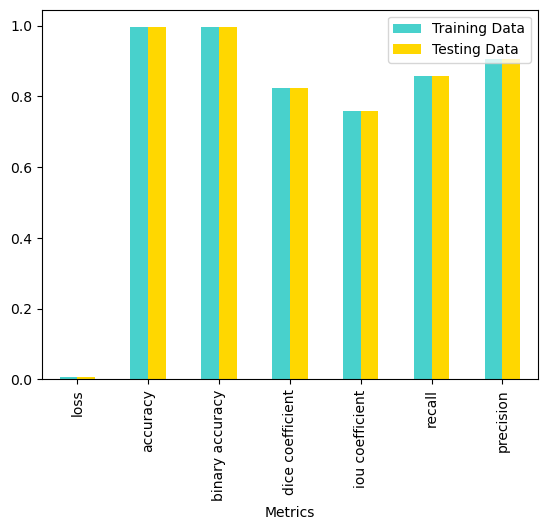

In [19]:
colors = ['mediumturquoise','gold']
df.plot(kind = 'bar',color=colors)

1/1 [==============================] - 0s 61ms/step
(128, 128, 1)
(128, 128, 1)
(128, 128)
(128, 128)


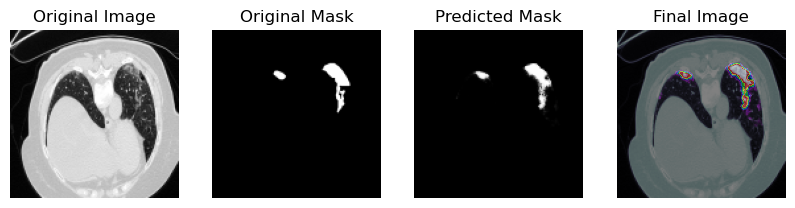

In [24]:
ans = []
img = CT_test[468]
tt = CT_test[468] 
img = img[np.newaxis, :, :, :]
pmask = model.predict(img)
pmask = np.squeeze(pmask)
ans.append(CT_test[468])
ans.append(Mask_test[468])
ans.append(pmask)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
titles = ['Original Image', 'Original Mask','Predicted Mask','Final Image']
for i in range(3):
    ax[i].imshow(ans[i],cmap='gray')
    print(ans[i].shape)
    ax[i].set_title(titles[i], fontsize=12)
    ax[i].axis('off')
    
ax[3].imshow(ans[0],cmap='bone')
ax[3].imshow(ans[2],alpha = 0.5, cmap = "nipy_spectral")
print(ans[i].shape)
ax[3].set_title(titles[3], fontsize=12)
ax[3].axis('off')

# Show the plot
plt.show()

<h4> Dataset 2:- Not trained in the unet model</h4>

(128, 128, 1)
1/1 [==============================] - 0s 71ms/step


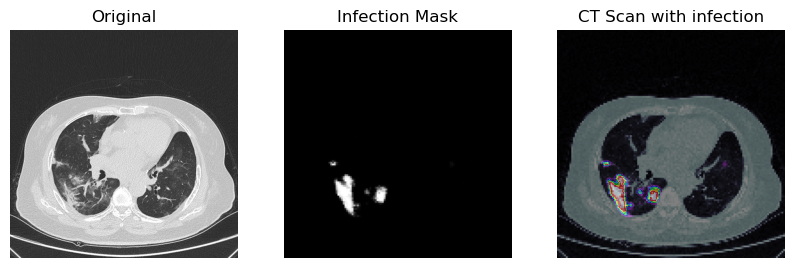

(128, 128, 1)
1/1 [==============================] - 0s 66ms/step


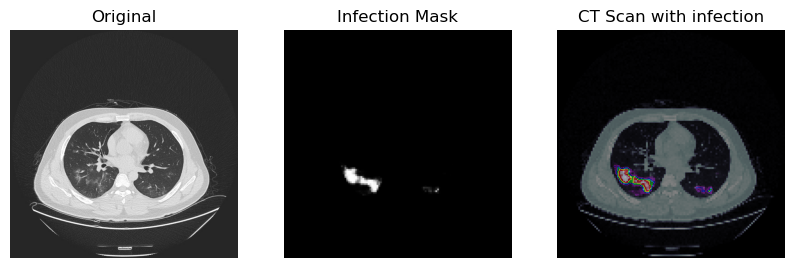

(128, 128, 1)
1/1 [==============================] - 0s 60ms/step


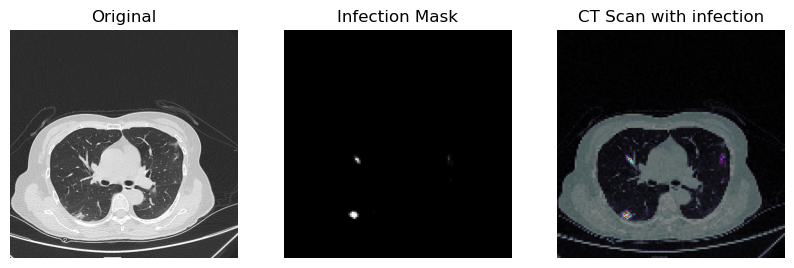

(128, 128, 1)
1/1 [==============================] - 0s 56ms/step


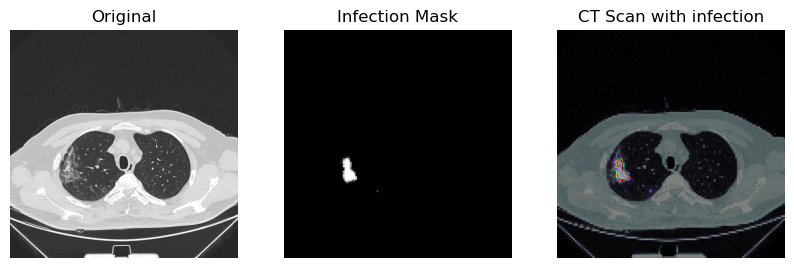

(128, 128, 1)
1/1 [==============================] - 0s 71ms/step


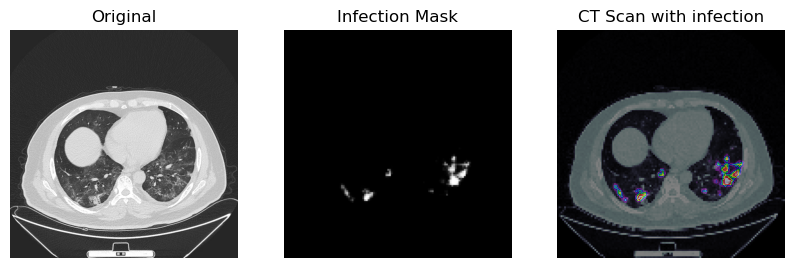

In [28]:
original,img,mask = get_images(r"Dataset1\Orginal\pCT\pCT1110.jpg",model)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
#titles = ['Original Image', 'Lung Mask', 'Lung Segmented']
ax[0].imshow(original)
ax[0].set_title("Original", fontsize=12)
ax[0].axis('off')

ax[1].imshow(mask,cmap='gray')
ax[1].set_title("Infection Mask", fontsize=12)
ax[1].axis('off')

ax[2].imshow(img,cmap='bone')
ax[2].imshow(mask,alpha = 0.5, cmap = "nipy_spectral")
ax[2].set_title("CT Scan with infection", fontsize=12)
ax[2].axis('off')

# Show the plot
plt.show()

original,img,mask = get_images(r"Dataset1\Orginal\pCT\pCT1231.jpg",model)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
#titles = ['Original Image', 'Lung Mask', 'Lung Segmented']
ax[0].imshow(original)
ax[0].set_title("Original", fontsize=12)
ax[0].axis('off')

ax[1].imshow(mask,cmap='gray')
ax[1].set_title("Infection Mask", fontsize=12)
ax[1].axis('off')

ax[2].imshow(img,cmap='bone')
ax[2].imshow(mask,alpha = 0.5, cmap = "nipy_spectral")
ax[2].set_title("CT Scan with infection", fontsize=12)
ax[2].axis('off')

# Show the plot
plt.show()

original,img,mask = get_images(r"Dataset1\Orginal\pCT\pCT1001.jpg",model)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
#titles = ['Original Image', 'Lung Mask', 'Lung Segmented']
ax[0].imshow(original)
ax[0].set_title("Original", fontsize=12)
ax[0].axis('off')

ax[1].imshow(mask,cmap='gray')
ax[1].set_title("Infection Mask", fontsize=12)
ax[1].axis('off')

ax[2].imshow(img,cmap='bone')
ax[2].imshow(mask,alpha = 0.5, cmap = "nipy_spectral")
ax[2].set_title("CT Scan with infection", fontsize=12)
ax[2].axis('off')

# Show the plot
plt.show()

original,img,mask = get_images(r"Dataset1\Orginal\pCT\pCT100.jpg",model)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
#titles = ['Original Image', 'Lung Mask', 'Lung Segmented']
ax[0].imshow(original)
ax[0].set_title("Original", fontsize=12)
ax[0].axis('off')

ax[1].imshow(mask,cmap='gray')
ax[1].set_title("Infection Mask", fontsize=12)
ax[1].axis('off')

ax[2].imshow(img,cmap='bone')
ax[2].imshow(mask,alpha = 0.5, cmap = "nipy_spectral")
ax[2].set_title("CT Scan with infection", fontsize=12)
ax[2].axis('off')

# Show the plot
plt.show()

original,img,mask = get_images(r"Dataset1\Orginal\pCT\pCT1223.jpg",model)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
#titles = ['Original Image', 'Lung Mask', 'Lung Segmented']
ax[0].imshow(original)
ax[0].set_title("Original", fontsize=12)
ax[0].axis('off')

ax[1].imshow(mask,cmap='gray')
ax[1].set_title("Infection Mask", fontsize=12)
ax[1].axis('off')

ax[2].imshow(img,cmap='bone')
ax[2].imshow(mask,alpha = 0.5, cmap = "nipy_spectral")
ax[2].set_title("CT Scan with infection", fontsize=12)
ax[2].axis('off')

# Show the plot
plt.show()